# PyTorch on macOS Guide

This notebook provides a comprehensive guide for using PyTorch effectively on macOS, with a focus on:

1. Setting up PyTorch with hardware acceleration
2. Using Metal Performance Shaders (MPS) on Apple Silicon
3. Working with BERT models using PyTorch on Mac
4. Performance optimization techniques
5. Troubleshooting common issues

In [21]:
import torch
import platform

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Check for MPS (Metal Performance Shaders) on macOS with Apple Silicon
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
print(f"MPS available: {mps_available}")
print(f"System: {platform.system()} {platform.machine()}")

# Determine the best available device
device = "cuda" if torch.cuda.is_available() else "mps" if mps_available else "cpu"
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0
CUDA available: False
MPS available: True
System: Darwin arm64
Using device: mps


# Using PyTorch on macOS

This notebook demonstrates how to effectively use PyTorch on macOS, including hardware acceleration with Metal Performance Shaders (MPS) on Apple Silicon devices (M1/M2/M3).

In [2]:
# Example: Using MPS for hardware acceleration on macOS

# Determine the best available device
device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Create a sample tensor and move it to the device
x = torch.rand(5, 3)
x = x.to(device)
print(f"Tensor created on {device}:\n{x}")

# Simple matrix multiplication example
y = torch.rand(3, 2).to(device)
z = torch.matmul(x, y)
print(f"Matrix multiplication result:\n{z}")

# Compare performance between CPU and device (if MPS/CUDA is available)
import time

# Function to measure performance
def measure_performance(device_type, size=1000):
    start = time.time()

    # Create matrices on the specified device
    matrix1 = torch.rand(size, size, device=device_type)
    matrix2 = torch.rand(size, size, device=device_type)

    # Matrix multiplication
    result = torch.matmul(matrix1, matrix2)

    # Force computation to complete (important for timing)
    result.mean().item()

    end = time.time()
    return end - start

# Only compare if we have hardware acceleration
if device != "cpu":
    cpu_time = measure_performance("cpu", size=1000)
    device_time = measure_performance(device, size=1000)
    speedup = cpu_time / device_time

    print(f"\nPerformance comparison for 1000x1000 matrix multiplication:")
    print(f"CPU time: {cpu_time:.4f} seconds")
    print(f"{device.upper()} time: {device_time:.4f} seconds")
    print(f"Speedup: {speedup:.2f}x")

Using device: mps
Tensor created on mps:
tensor([[0.3890, 0.0666, 0.9399],
        [0.2088, 0.2788, 0.2158],
        [0.7727, 0.8135, 0.2127],
        [0.8628, 0.5630, 0.9082],
        [0.1651, 0.7615, 0.7113]], device='mps:0')
Matrix multiplication result:
tensor([[1.1655, 0.1997],
        [0.5208, 0.0950],
        [1.1879, 0.2541],
        [1.7323, 0.3345],
        [1.3454, 0.1998]], device='mps:0')

Performance comparison for 1000x1000 matrix multiplication:
CPU time: 0.0040 seconds
MPS time: 0.0109 seconds
Speedup: 0.36x


In [22]:
import os
import pickle
import subprocess
import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import requests
import json

In [24]:
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.pytorch

from dotenv import load_dotenv

# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8081


In [37]:
# Create a new MLflow Experiment
experiment_name = "P7-Sentiments_Analysis_neural_network"

# Check if the experiment exists, create it if it doesn't
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")

# Set the experiment
mlflow.set_experiment(experiment_name)

Using existing experiment 'P7-Sentiments_Analysis_neural_network' with ID: 859618380264734882


<Experiment: artifact_location='mlflow-artifacts:/859618380264734882', creation_time=1760707139984, experiment_id='859618380264734882', last_update_time=1760707139984, lifecycle_stage='active', name='P7-Sentiments_Analysis_neural_network', tags={}>

# Load and prepare data

In [26]:
df_sample = pd.read_csv('../data/processed_sample_tweets.csv')
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   target                        50000 non-null  int64 
 1   ids                           50000 non-null  int64 
 2   date                          50000 non-null  object
 3   user                          50000 non-null  object
 4   text                          50000 non-null  object
 5   processed_text_lem            50000 non-null  object
 6   advanced_processed_text_lem   50000 non-null  object
 7   processed_text_stem           50000 non-null  object
 8   advanced_processed_text_stem  50000 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.4+ MB


In [27]:
display(df_sample['target'].value_counts())

target
0    25000
1    25000
Name: count, dtype: int64

In [28]:
def preprocess_tweet_for_bert(tweet):
    import re
    if not isinstance(tweet, str):
        return ""
    tweet = re.sub(r"http\S+", "URL", tweet)
    tweet = re.sub(r"@\w+", "USER", tweet)
    tweet = re.sub(r'#(\w+)', r'#\1', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip().lower()
    return tweet

In [30]:
# Split data into training and test sets
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        df_sample['text'].values,
        df_sample['target'].values,
        test_size=0.2,
        random_state=42
    )

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,
    random_state=42
)

data = {
        'train': {'texts': train_texts, 'labels': train_labels},
        'val': {'texts': val_texts, 'labels': val_labels},
        'test': {'texts': test_texts, 'labels': test_labels}
    }

# Dataset definition

In [31]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenisation
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Evaluation method

In [32]:
def evaluate_model(model, test_loader, device):
    """
    Model evaluation on the test dataset.
    """
    model.eval()
    test_preds, test_true = [], []
    test_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test set evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Predictions and probabilities
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            test_preds.extend(preds)
            test_true.extend(true)
            test_probs.extend(probs[:, 1].cpu().numpy())  # Positive class probabilities

    # Metrics
    accuracy = accuracy_score(test_true, test_preds)
    precision = precision_score(test_true, test_preds)
    recall = recall_score(test_true, test_preds)
    f1 = f1_score(test_true, test_preds)

    # Matrice de confusion
    cm = confusion_matrix(test_true, test_preds)

    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    # Classification report
    report = classification_report(test_true, test_preds, target_names=['Negative', 'Positive'])

    # Courbe ROC et AUC
    fpr, tpr, _ = roc_curve(test_true, test_probs)
    roc_auc = auc(fpr, tpr)

    # Regrouper toutes les métriques
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': test_preds,
        'true_labels': test_true,
        'probabilities': test_probs
    }

    return metrics

# Vizualisation

In [33]:
# CONFUSION MATRIX VISUALIZATION
def plot_confusion_matrix(cm, class_names, model):
    """
    Plot and save the confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion')

    # Ensure directory exists
    os.makedirs('../artifacts/confusion_matrix', exist_ok=True)

    # Save confusion matrix
    filename = f'../artifacts/confusion_matrix/confusion_matrix_{model}.png'
    plt.savefig(filename)

    # Log to MLflow
    mlflow.log_artifact(filename, "confusion_matrix")

    return plt.gcf()

# ROC CURVE VISUALIZATION
def plot_roc_curve(fpr, tpr, roc_auc, model):
    """
    Plot and save the ROC curve.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Ensure directory exists
    os.makedirs('../artifacts/roc_curve', exist_ok=True)

    # Save ROC curve
    filename = f'../artifacts/roc_curve/roc_curve_{model}.png'
    plt.savefig(filename)

    # Log to MLflow
    mlflow.log_artifact(filename, "roc_curve")

    return plt.gcf()

# TRAINING HISTORY VISUALIZATION
def plot_training_history(history, model):
    """
    Plot and save training and validation loss and accuracy over epochs.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()

    # Ensure directory exists
    os.makedirs('../artifacts/Learning_cruve', exist_ok=True)

    # Save training history
    filename = f'../artifacts/Learning_cruve/learning_curve_{model}.png'
    plt.savefig(filename)

    # Log to MLflow
    mlflow.log_artifact(filename, "learning_curves")

    # Also log metrics history as JSON for potential later use
    history_path = f'../artifacts/history_{model}.json'
    with open(history_path, 'w') as f:
        json.dump(history, f)
    mlflow.log_artifact(history_path, "history")

    return plt.gcf()

# Add a new function to log evaluation metrics to MLflow
def log_metrics_to_mlflow(metrics, model_name, run_name=None):
    """
    Log evaluation metrics to MLflow.

    Args:
        metrics (dict): Dictionary containing evaluation metrics
        model_name (str): Name of the model
        run_name (str, optional): Name for the MLflow run
    """
    with mlflow.start_run(run_name=run_name):
        # Log model parameters
        mlflow.log_param("model_name", model_name)

        # Log metrics
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("precision", metrics['precision'])
        mlflow.log_metric("recall", metrics['recall'])
        mlflow.log_metric("f1", metrics['f1'])
        mlflow.log_metric("specificity", metrics['specificity'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])

        # Log confusion matrix
        plot_confusion_matrix(metrics['confusion_matrix'], ['Negative', 'Positive'], model_name)

        # Log ROC curve
        plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'], model_name)

        # Log classification report
        report_path = f'../artifacts/classification_report_{model_name}.txt'
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, 'w') as f:
            f.write(metrics['classification_report'])
        mlflow.log_artifact(report_path, "classification_report")

        # Log predictions and true labels
        pred_df = pd.DataFrame({
            'true_label': metrics['true_labels'],
            'predicted_label': metrics['predictions'],
            'probability': metrics['probabilities']
        })
        pred_path = f'../artifacts/predictions_{model_name}.csv'
        os.makedirs(os.path.dirname(pred_path), exist_ok=True)
        pred_df.to_csv(pred_path, index=False)
        mlflow.log_artifact(pred_path, "predictions")

        print(f"All metrics and visualizations logged to MLflow run: {mlflow.active_run().info.run_id}")

# Training

In [40]:
def train_model(model, train_loader, val_loader, test_loader, device, epochs=3, gradient_accumulation_steps=4, model_name="bert_uncase"):
    """
    Trains the BERT model with mixed precision and gradient accumulation.

    Args:
        model : BERT model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        device: Device to run the training on (cuda/cpu)
        epochs: Number of training epochs
        gradient_accumulation_steps: Number of steps to accumulate gradients
        model_name: Name to identify the model in MLflow

    Returns:
        tuple: (history, test_metrics) - Training history and final test metrics
    """
    # Start MLflow run
    with mlflow.start_run(run_name=f"Training_{model_name}"):
        # Log model parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("gradient_accumulation_steps", gradient_accumulation_steps)
        mlflow.log_param("device", device)
        mlflow.log_param("batch_size", train_loader.batch_size)
        mlflow.log_param("learning_rate", 2e-5)

        # optimisation
        optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

        # Initialize scaler
        scaler = GradScaler()

        # Scheduler to adjust learning rate
        total_steps = len(train_loader) * epochs // gradient_accumulation_steps
        scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            train_preds, train_true = [], []

            train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')

            optimizer.zero_grad()

            for batch_idx, batch in enumerate(train_progress_bar):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                # Forward pass with autocast for mixed precision
                with autocast(device_type=device):
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    loss = outputs.loss / gradient_accumulation_steps

                # Backward pass with GradScaler
                scaler.scale(loss).backward()

                # Weight update after accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                    scaler.step(optimizer)
                    scheduler.step()
                    scaler.update()
                    optimizer.zero_grad()

                # Loss accumulation and prediction calculation
                train_loss += loss.item() * gradient_accumulation_steps
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                true = labels.cpu().numpy()

                train_preds.extend(preds)
                train_true.extend(true)

                train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

            # Metrics
            train_accuracy = accuracy_score(train_true, train_preds)
            avg_train_loss = train_loss / len(train_loader)

            history['train_loss'].append(avg_train_loss)
            history['train_accuracy'].append(train_accuracy)

            print(f"\nEpoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.3f}")
            print(f"Epoch {epoch+1}/{epochs} - Training accuracy: {train_accuracy:.3f}")

            # Log epoch metrics to MLflow
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)

            # Validation
            model.eval()
            val_loss = 0.0
            val_preds, val_true = [], []
            val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')

            with torch.no_grad():
                for batch in val_progress_bar:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss
                    val_loss += loss.item()

                    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    true = labels.cpu().numpy()

                    val_preds.extend(preds)
                    val_true.extend(true)

                    val_progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item())})

            val_accuracy = accuracy_score(val_true, val_preds)
            avg_val_loss = val_loss / len(val_loader)

            history['val_loss'].append(avg_val_loss)
            history['val_accuracy'].append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs} - Validation loss: {avg_val_loss:.3f}")
            print(f"Epoch {epoch+1}/{epochs} - Validation accuracy: {val_accuracy:.3f}")

            # Log validation metrics to MLflow
            mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

        # Plot and log training history
        plot_training_history(history, model_name)

        # Final evaluation on test set
        test_metrics = evaluate_model(model, test_loader, device)

        # Log test metrics
        for metric_name, metric_value in test_metrics.items():
            if isinstance(metric_value, (int, float)) and not isinstance(metric_value, bool):
                mlflow.log_metric(f"test_{metric_name}", metric_value)

        # Log confusion matrix and ROC curve
        plot_confusion_matrix(test_metrics['confusion_matrix'], ['Negative', 'Positive'], model_name)
        plot_roc_curve(test_metrics['fpr'], test_metrics['tpr'], test_metrics['roc_auc'], model_name)

        # Log classification report
        report_path = f'../artifacts/classification_report_{model_name}.txt'
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, 'w') as f:
            f.write(test_metrics['classification_report'])
        mlflow.log_artifact(report_path, "classification_report")

        # Save and log the model
        model_path = f"../models/{model_name}"
        os.makedirs(model_path, exist_ok=True)
        torch.save(model.state_dict(), f"{model_path}/model.pt")

        # Define model signature for MLflow
        input_sample = {
            'input_ids': torch.zeros((1, 128), dtype=torch.long),
            'attention_mask': torch.zeros((1, 128), dtype=torch.long)
        }
        output_sample = torch.tensor([[0.1, 0.9]])

        signature = infer_signature(
            model_input=input_sample,
            model_output=output_sample
        )

        # Log the PyTorch model to MLflow
        mlflow.pytorch.log_model(
            model,
            artifact_path="models",
            registered_model_name=model_name,
            signature=signature
        )

        print(f"Model saved and logged to MLflow: {model_name}")

        # Return history and test metrics
        return history, test_metrics

Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/3 (Training): 100%|██████████| 2000/2000 [10:02<00:00,  3.32it/s, training_loss=0.199]



Epoch 1/3 - Training loss: 0.432
Epoch 1/3 - Training accuracy: 0.800


Epoch 1/3 (Validation): 100%|██████████| 500/500 [00:46<00:00, 10.70it/s, validation_loss=0.580]


Epoch 1/3 - Validation loss: 0.407
Epoch 1/3 - Validation accuracy: 0.815


Epoch 2/3 (Training): 100%|██████████| 2000/2000 [09:44<00:00,  3.42it/s, training_loss=0.067]



Epoch 2/3 - Training loss: 0.316
Epoch 2/3 - Training accuracy: 0.869


Epoch 2/3 (Validation): 100%|██████████| 500/500 [00:47<00:00, 10.57it/s, validation_loss=0.692]


Epoch 2/3 - Validation loss: 0.395
Epoch 2/3 - Validation accuracy: 0.828


Epoch 3/3 (Training): 100%|██████████| 2000/2000 [09:45<00:00,  3.42it/s, training_loss=0.023]



Epoch 3/3 - Training loss: 0.239
Epoch 3/3 - Training accuracy: 0.907


Epoch 3/3 (Validation): 100%|██████████| 500/500 [00:47<00:00, 10.58it/s, validation_loss=0.745]


Epoch 3/3 - Validation loss: 0.424
Epoch 3/3 - Validation accuracy: 0.829


Test set evaluation: 100%|██████████| 625/625 [00:57<00:00, 10.85it/s]
2025/10/23 01:06:29 WARNING mlflow.models.signature: Failed to infer schema for inputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. Note that MLflow doesn't validate data types during inference for AnyType. To see the full traceback, set logging level to DEBUG.
2025/10/23 01:06:29 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/10/23 01:06:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 01:06:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'bert_uncase' already exists. Creating a new version of this model...
2025/10/23 01:07:24 INFO mlflow.store.model_registry.abstract_stor

Model saved and logged to MLflow: bert_uncase
🏃 View run Training_bert_uncase at: http://localhost:8081/#/experiments/859618380264734882/runs/0a2bed8f8e67438e9ea54bf1bda7f458
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Final Test Results:
Accuracy: 0.8368
Precision: 0.8372
Recall: 0.8345
F1 Score: 0.8358
ROC AUC: 0.9118


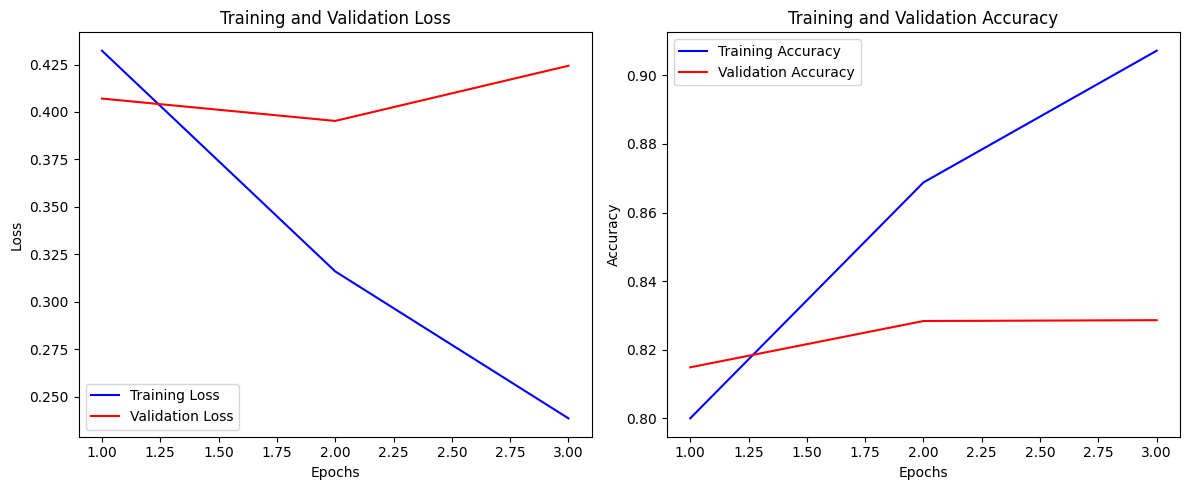

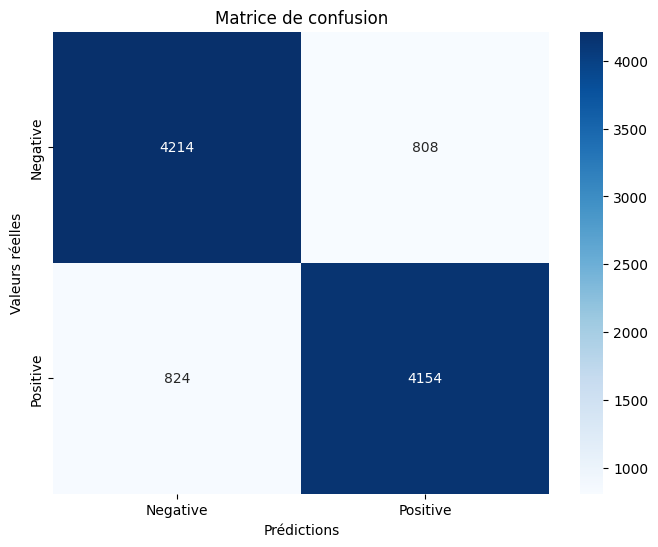

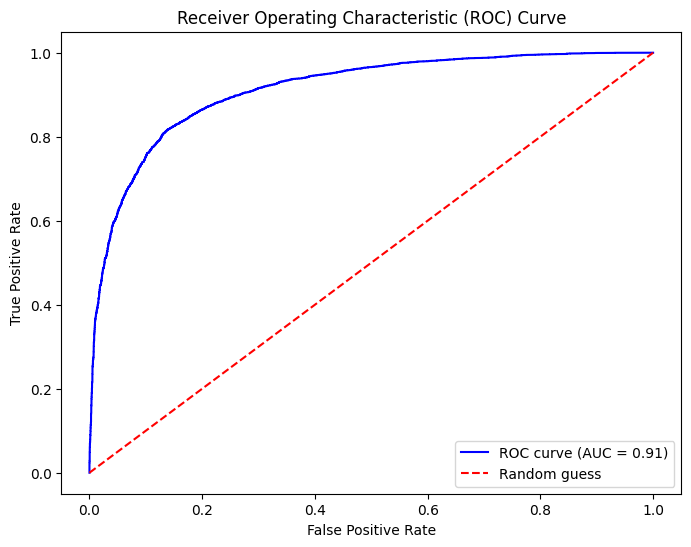

In [41]:
def run_bert_experiment(model_name="bert_uncase", batch_size=16, epochs=3):
    """
    Run a complete BERT experiment with MLflow tracking
    """
    # Set device
    device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")

    # Initialize tokenizer and model
    if model_name == "distilbert":
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    elif model_name == "bert_uncase":
        from transformers import BertTokenizer, BertForSequenceClassification
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    else:
        # Fallback to another model or raise error
        raise ValueError(f"Model {model_name} not supported")

    model = model.to(device)

    # Create datasets
    train_dataset = TweetDataset(data['train']['texts'], data['train']['labels'], tokenizer)
    val_dataset = TweetDataset(data['val']['texts'], data['val']['labels'], tokenizer)
    test_dataset = TweetDataset(data['test']['texts'], data['test']['labels'], tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Train model with MLflow tracking
    history, test_metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=epochs,
        model_name=model_name
    )

    # Print final results
    print("\nFinal Test Results:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")

    return model, tokenizer, test_metrics

# Run the experiment
if __name__ == "__main__":
    model_name = "bert_uncase"
    model, tokenizer, metrics = run_bert_experiment(model_name=model_name,epochs=3, batch_size=16)

    # Save the tokenizer for later use
    tokenizer_path = f"../models/{model_name}/tokenizer"
    os.makedirs(tokenizer_path, exist_ok=True)
    tokenizer.save_pretrained(tokenizer_path)